# Bus Current Injection

In [1]:
import numpy as np

import andes

from andes.linsolvers.scipy import spmatrix_to_csc

import scipy.sparse as sps

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
andes.config_logger(20)

In [4]:
ss = andes.load(andes.get_case('kundur/kundur_full.xlsx'),
                setup=True, no_output=True, default_config=True,
                pert="./pert.py")

Working directory: "/Users/jinningwang/work/demo/demo/bus_current_injection"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 12 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1608 seconds.
Parsing input file "/Users/jinningwang/work/andes/andes/cases/kundur/kundur_full.xlsx"...
Input file parsed in 0.1475 seconds.
System internal structure set up in 0.0133 seconds.


ANDES allows bus admittance matrix calculation.

In [5]:
Y = spmatrix_to_csc(ss.Line.build_y()).todense()
Y.shape

(10, 10)

In [6]:
ss.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0024 seconds.
0: |F(x)| = 14.9282832
1: |F(x)| = 3.608627841
2: |F(x)| = 0.1701107882
3: |F(x)| = 0.002038626956
4: |F(x)| = 3.745103979e-07
Converged in 5 iterations in 0.0029 seconds.


True

In [7]:
# --- Cft ---
ss.nb = ss.Bus.n
ss.nl = ss.Line.n

# line indices: idx -> uid
idx_line = ss.Line.idx.v
u_line = ss.Line.get(src='u', attr='v', idx=idx_line)
on_line = np.flatnonzero(u_line)
on_line_idx = [idx_line[i] for i in on_line]
on_line_bus1 = ss.Line.get(src='bus1', attr='v', idx=on_line_idx)
on_line_bus2 = ss.Line.get(src='bus2', attr='v', idx=on_line_idx)

data_line = np.ones(2*len(on_line_idx))
data_line[len(on_line_idx):] = -1
row_line = np.array([ss.Bus.idx2uid(x) for x in on_line_bus1 + on_line_bus2])
col_line = np.array([ss.Line.idx2uid(x) for x in on_line_idx + on_line_idx])
Cft = sps.csr_matrix((data_line, (row_line, col_line)), (ss.nb, ss.nl)).toarray()

ss.Cft = Cft
ss.Igen = np.zeros((1, ss.nb), dtype=complex)
ss.Iline = np.zeros((1, ss.nb), dtype=complex)

In [8]:
ss.TDS.config.tf = 30
ss.TDS.config.no_tqdm = True
ss.TDS.config.criteria = 0

ss.TDS.run()

ss.Igen = ss.Igen[1:, ]
ss.Iline = ss.Iline[1:, ]

Perturbation file "./pert.py" loaded.
Initialization for dynamics completed in 0.0147 seconds.
Initialization was successful.


<Toggle 1>: Line.Line_8 status changed to 0 at t=2.0 sec.


Simulation to t=30.00 sec completed in 0.8235 seconds.


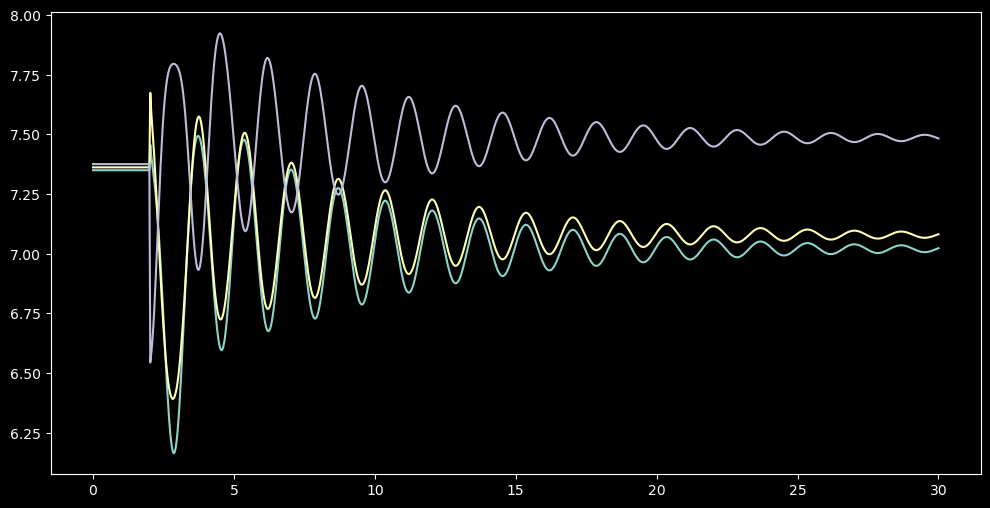

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# first bus
_ = ax.plot(ss.dae.ts.t, np.abs(ss.Igen)[:, [0, 1, 2]])